In [1]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
from keybert import KeyBERT


c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing

In [24]:
df = pd.read_csv('https://raw.githubusercontent.com/arsyadCode/My_Thesis/main/Program/Data/Update/Scopus.csv')

In [3]:
nlp = spacy.load('en_core_web_sm') 

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    words = [token.text for token in doc if 
                len(token) > 2 and
                token.pos_ not in ['VERB', 'ADJ', "GPE", "ADP", "NUM", "AUX", "ADV"] and
                token.lemma_ and 
                not token.is_stop and
                not token.is_digit and 
                not token.is_currency and 
                not token.is_space
            ]
    return ' '.join(words)

# Melakukan preprocessing pada kolom 'abstrak'
df['Abstrak'] = df['Abstract'].apply(preprocess_text)
data = df['Abstrak']
df['Abstract'] = df['Abstract'].apply(preprocess_text)

In [4]:
display(df['Abstrak'].head())
df['Abstract'].head()

0    the covid19 pandemic has the course the econom...
1    government has strongly announcement the publi...
2    carbon storage peat ecosystems over thousands ...
3    sector one the energyconsuming districts count...
4    interventions forests have deforestation and f...
Name: Abstrak, dtype: object

0    the covid19 pandemic has the course the econom...
1    government has strongly announcement the publi...
2    carbon storage peat ecosystems over thousands ...
3    sector one the energyconsuming districts count...
4    interventions forests have deforestation and f...
Name: Abstract, dtype: object

In [5]:
def extract_keywords(sentence):
    doc = nlp(sentence)
    keywords = [str(token.text.lower()) for token in doc if token.lemma_]
    return keywords

def extract_keywords2(sentence):
    doc = nlp(sentence)
    keywords2 = [str(token.text.lower()) for token in doc if not token.is_stop]
    return keywords2

keywords_array = []
keywords_array2 = []

# Similiar with Unigram
for _, row in df.iterrows():
    sentence2 = row['Abstrak']
    keywords2 = extract_keywords2(sentence2)
    keywords_array2.extend(keywords2)

for _, row in df.iterrows():
    sentence = row['Abstract']
    keywords = extract_keywords(sentence)
    keywords_array.extend(keywords)

keywords_list2 = pd.DataFrame(list(set(keywords_array2)))
keywords_list = pd.DataFrame(list(set(keywords_array)))
abstract_count2 = Counter(keywords_array2)
abstract_count = Counter(keywords_array)

result_dict = {key: abstract_count[key] for key in keywords_array if key in abstract_count}
sorted_result = dict(sorted(result_dict.items(), key=lambda item: (item[1], item[0])))
result_dict2 = {key: abstract_count2[key] for key in keywords_array2 if key in abstract_count2}
sorted_result2 = dict(sorted(result_dict2.items(), key=lambda item: (item[1], item[0])))

In [6]:
display(abstract_count)
abstract_count2

Counter({'the': 5030,
         'and': 2808,
         'for': 750,
         'emissions': 678,
         'that': 677,
         'this': 629,
         'from': 608,
         'indonesia': 460,
         'with': 451,
         'energy': 417,
         'are': 407,
         'was': 395,
         'greenhouse': 382,
         'gas': 371,
         'study': 339,
         'ghg': 314,
         'carbon': 302,
         'emission': 300,
         'has': 291,
         'oil': 283,
         'were': 282,
         'palm': 251,
         'co2': 238,
         'which': 232,
         'production': 231,
         'climate': 229,
         'change': 207,
         'can': 191,
         'forest': 188,
         'results': 183,
         'land': 177,
         'research': 169,
         'have': 161,
         'also': 160,
         'development': 157,
         'impact': 156,
         'under': 154,
         'data': 152,
         'one': 152,
         'these': 150,
         'use': 149,
         'its': 146,
         'all': 141,
         '

Counter({'emissions': 678,
         'indonesia': 460,
         'energy': 417,
         'greenhouse': 382,
         'gas': 371,
         'study': 339,
         'ghg': 314,
         'carbon': 302,
         'emission': 300,
         'oil': 283,
         'palm': 251,
         'co2': 238,
         'production': 231,
         'climate': 229,
         'change': 207,
         'forest': 188,
         'results': 183,
         'land': 177,
         'research': 169,
         'development': 157,
         'impact': 156,
         'data': 152,
         'use': 149,
         'soil': 137,
         'power': 129,
         'countries': 126,
         'ch4': 125,
         'rice': 125,
         'water': 122,
         'peat': 121,
         'system': 120,
         'area': 113,
         'management': 110,
         'analysis': 106,
         'ltd': 106,
         'impacts': 106,
         'factors': 103,
         'consumption': 102,
         'industry': 102,
         'method': 101,
         'gases': 96,
         'mod

In [7]:
# Jumlah data untuk Teori Luhn dan Clustering
print(len(keywords_list), len(keywords_list2))

4754 4580


In [23]:
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text)
    words = [token.text for token in doc if 
                len(token) > 2 and
                token.pos_ not in ['VERB', 'ADJ', "GPE", "ADP", "NUM", "AUX", "ADV"] and
                token.lemma_ and 
                not token.is_stop and
                not token.is_digit and 
                not token.is_currency and 
                not token.is_space
            ]
    return words

# Example usage with text from "Lord of the Flies"
lotf_text = df['Abstract'][0]

preprocessed_words = preprocess_text(lotf_text)

# Extract and print the pos_ values of the tokens
pos_values = [(token.text, token.pos_) for token in nlp(lotf_text)]
print(pos_values)
print(preprocessed_words)


[('The', 'DET'), ('covid-19', 'PROPN'), ('pandemic', 'ADJ'), ('has', 'AUX'), ('altered', 'VERB'), ('the', 'DET'), ('course', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('economy', 'NOUN'), ('all', 'ADV'), ('over', 'ADP'), ('the', 'DET'), ('world', 'NOUN'), (',', 'PUNCT'), ('including', 'VERB'), ('Indonesia', 'PROPN'), ('.', 'PUNCT'), ('Government', 'NOUN'), ('policy', 'NOUN'), ('to', 'PART'), ('resort', 'VERB'), ('to', 'ADP'), ('social', 'ADJ'), ('restriction', 'NOUN'), ('and', 'CCONJ'), ('working', 'VERB'), ('from', 'ADP'), ('home', 'NOUN'), ('has', 'AUX'), ('increased', 'VERB'), ('household', 'NOUN'), ('consumption', 'NOUN'), ('of', 'ADP'), ('energy', 'NOUN'), ('but', 'CCONJ'), ('reduce', 'VERB'), ('the', 'DET'), ('commercial', 'ADJ'), ('use', 'NOUN'), ('of', 'ADP'), ('energy', 'NOUN'), ('.', 'PUNCT'), ('Economic', 'ADJ'), ('growth', 'NOUN'), ('is', 'AUX'), ('greatly', 'ADV'), ('affected', 'VERB'), ('by', 'ADP'), ('the', 'DET'), ('pandemic', 'ADJ'), ('and', 'CCONJ'), ('had', 'AUX'), ('s

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/arsyadCode/My_Thesis/main/Program/Data/Update/Scopus.csv')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    doc = nlp(text)
    words = [token.text for token in doc if 
                len(token)>2 and
                token.pos_ and
                token.lemma_ and
                not token.is_stop
                not in ['VERB', 'ADJ', "GPE", "ADP", "NOUN"] and 
                not token.is_digit and 
                not token.is_currency and 
                not token.is_space and 
                not token.text.isnumeric()
            ]
    return ' '.join(words)

# Melakukan preprocessing pada kolom 'abstrak'
df['Abstrak'] = df['Abstract'].apply(preprocess_text)
data = df['Abstrak']

In [14]:
data[0]

''

# K-Means Clustering

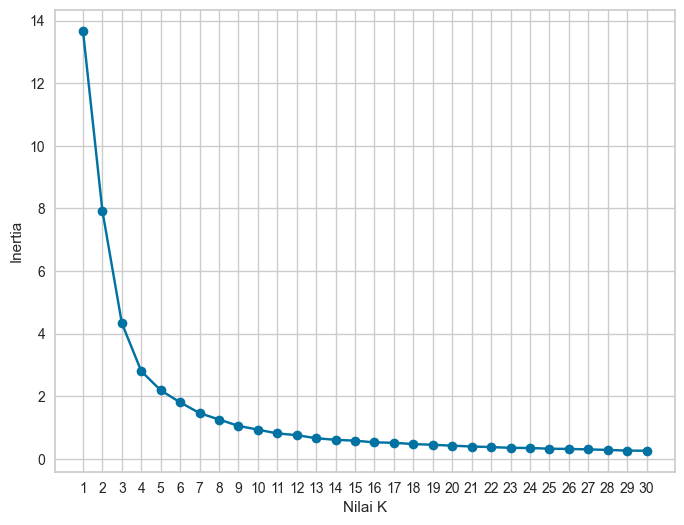

In [24]:
vectorizer = TfidfVectorizer(max_features=len(keywords_list2))
X = vectorizer.fit_transform(df['Abstrak'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

num_clusters_range = range(1, 31)
inertia_values = []

for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(num_clusters_range, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('Nilai K')
plt.ylabel('Inertia')
# plt.title('Elbow Plot untuk menentukan Cluster K-Means')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

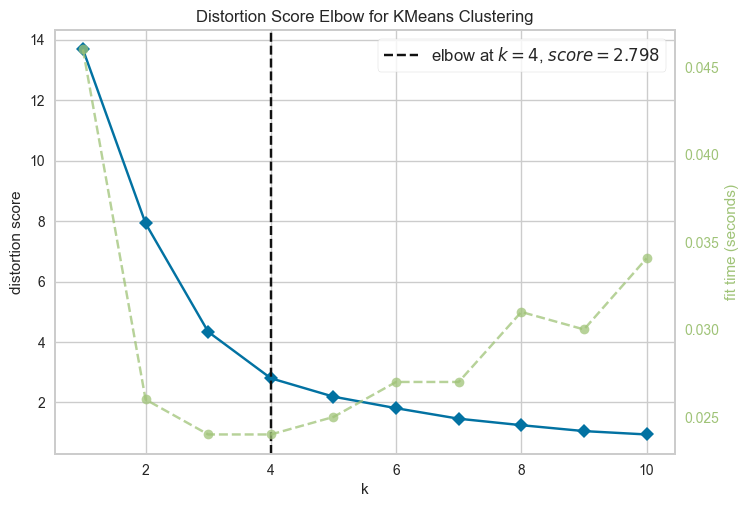

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 11))
visualizer.fit(X_pca)
visualizer.show()

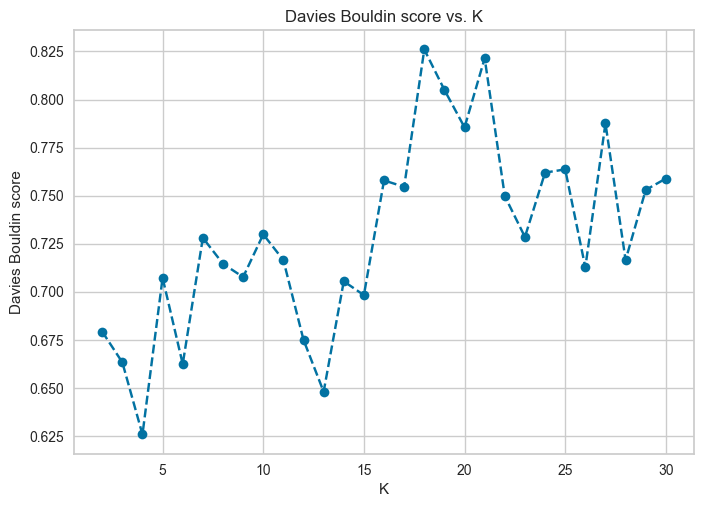

In [26]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score

def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit_predict(data)
    score = davies_bouldin_score(data, model)
    return score

# Perform PCA on the data before clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_pca)

scores = []
centers = list(range(2, 31))
for center in centers:
    scores.append(get_kmeans_score(X_pca, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. K')
plt.show()

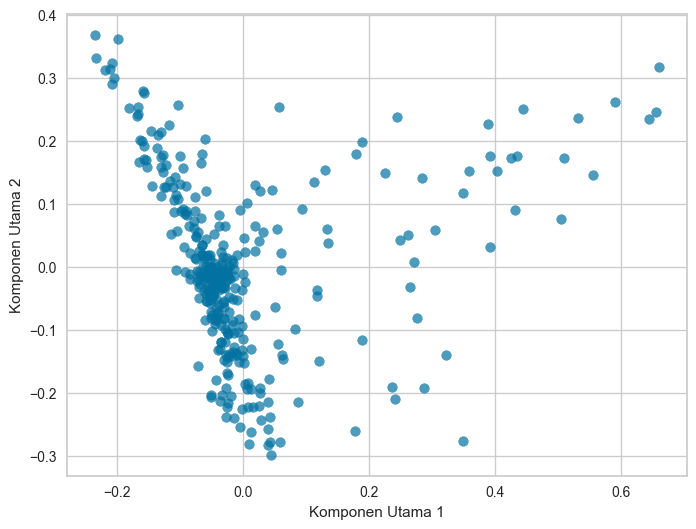

In [27]:
# Visualisasi PCA
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
# plt.title('Visualisasi klaster hasil dari PCA')
plt.grid(True)
plt.show()

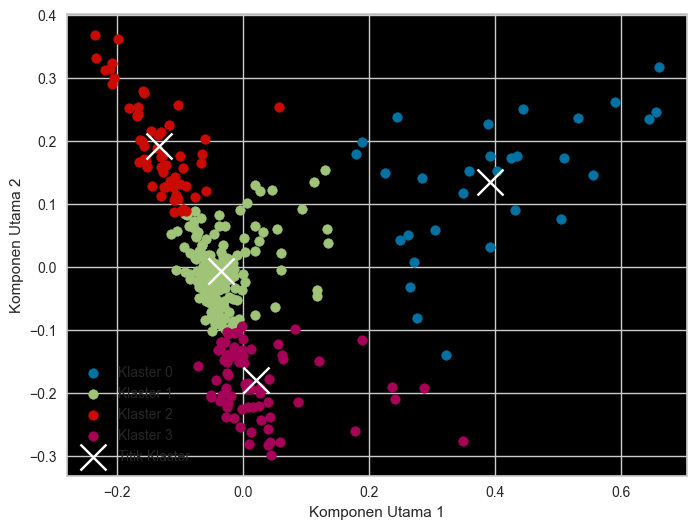

In [44]:
num_clusters = 4  # Setelah didapatkan pada proses sebelumnya
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_pca)

cluster_labels = kmeans.labels_
cluster_centers = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = X_pca[cluster_labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Klaster {i}')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=350, c='white', label='Titik Klaster')

# for i, abstract in enumerate(df['Abstrak']):
#     plt.text(X_pca[i, 0], X_pca[i, 1], f"{i+1}")

plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
# plt.title('Klasterisasi Pewarnaan dengan K-Means')
plt.legend()
plt.grid(True)
plt.show()

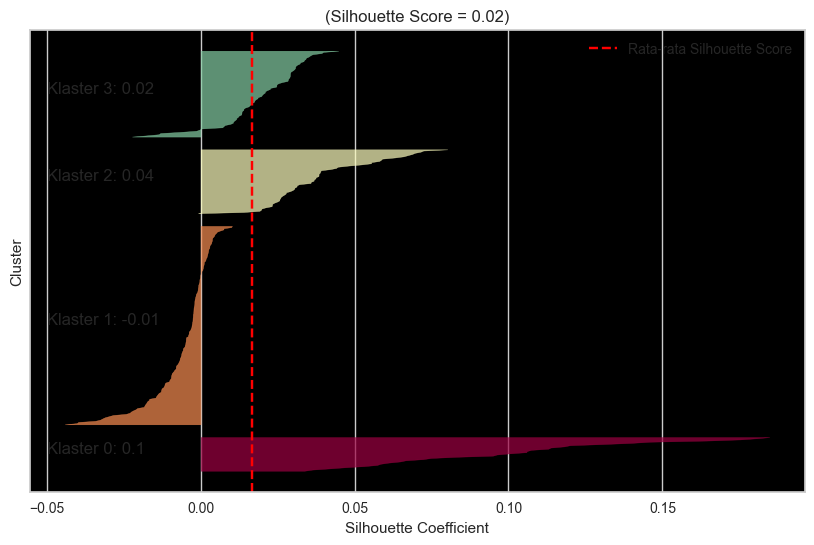

In [41]:
#Visualisasi Silhouette Clusters Plot

silhouette_avg = silhouette_score(X.toarray(), cluster_labels)
silhouette_values = silhouette_samples(X.toarray(), cluster_labels)

plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(num_clusters):
    ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = plt.cm.Spectral(float(i) / num_clusters)
    
    plt.fill_betweenx(np.arange(y_lower, y_upper), ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Klaster {i}: {round(np.mean(ith_cluster_silhouette_values), 2)}")
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--", label="Rata-rata Silhouette Score")

plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
# plt.title("Silhouette Plot untuk K-Means Clustering (Silhouette Score = " + str(round(silhouette_avg, 2)) + ")")
plt.title("(Silhouette Score = " + str(round(silhouette_avg, 2)) + ")")
plt.legend()
plt.yticks([])
plt.show()

In [15]:
# Hasil kata kunci berdasarkan hasil K-Means Clustering
vectorizer = TfidfVectorizer(max_features=len(keywords_list2))  
X = vectorizer.fit_transform(data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_pca)

keywords_per_cluster = {}
for i in range(num_clusters):
    cluster_data = [data[j] for j in range(len(data)) if cluster_labels[j] == i]
    cluster_text = ' '.join(cluster_data)
    cluster_vectorizer = TfidfVectorizer()
    cluster_X = cluster_vectorizer.fit_transform([cluster_text])
    feature_names = cluster_vectorizer.get_feature_names_out()
    tfidf_scores = cluster_X.toarray()[0]
    sorted_indices = np.argsort(tfidf_scores)[::-1]

    N = 20  #Total kata kunci yang diinginkan setiap cluster
    keywords = [feature_names[idx] for idx in sorted_indices[:N]]
    keywords_per_cluster[i] = keywords

for i in range(num_clusters):
    print(f"Cluster {i} Keywords: {', '.join(keywords_per_cluster[i])}")

Cluster 0 Keywords: oil, palm, emissions, indonesia, production, biodiesel, industry, gas, greenhouse, land, study, products, ghg, change, supply, soil, impact, expansion, ispo, sustainability
Cluster 1 Keywords: emissions, indonesia, greenhouse, study, emission, gas, ghg, carbon, climate, co2, production, change, results, energy, development, research, impact, data, countries, waste
Cluster 2 Keywords: energy, power, indonesia, emissions, gas, electricity, co2, consumption, generation, emission, greenhouse, plant, study, production, system, efficiency, ghg, development, impact, reduction
Cluster 3 Keywords: emissions, forest, peat, soil, rice, land, ch4, carbon, indonesia, greenhouse, ghg, gas, study, water, change, climate, area, emission, management, peatland


In [16]:
# Frasa berdasarkan 
kw_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

cluster_texts = {}
for i, abstract_text in enumerate(data):
    cluster_label = cluster_labels[i]
    if cluster_label not in cluster_texts:
        cluster_texts[cluster_label] = []
    cluster_texts[cluster_label].append(abstract_text)

for cluster_label, texts in cluster_texts.items():
    print(f"Cluster {cluster_label}:")
    keywords = kw_model.extract_keywords(texts, keyphrase_ngram_range=(1,2), top_n=5)
    print(keywords, '\n')

Cluster 2:
[[('electricity consumption', 0.59), ('economy electricity', 0.5713), ('energy use', 0.5702), ('energy generation', 0.5601), ('electricity demandsupply', 0.5558)], [('greenhouse gas', 0.5782), ('commitment greenhouse', 0.5302), ('demand co2', 0.4962), ('energy demand', 0.4849), ('contribution electricity', 0.4603)], [('emissions sources', 0.6573), ('greenhouse gases', 0.6003), ('emissions million', 0.5959), ('method emissions', 0.5921), ('emissions ways', 0.5848)], [('policies energy', 0.5583), ('emissions use', 0.5475), ('energy consumption', 0.5187), ('policymakers energy', 0.5179), ('energy market', 0.5157)], [('emissions indonesia', 0.657), ('indonesia emission', 0.623), ('indonesia energy', 0.6191), ('indonesia coal', 0.5956), ('carbon emissions', 0.5284)], [('sustainability concern', 0.6119), ('resources carbon', 0.5672), ('ecosystem deterioration', 0.5568), ('sustainability', 0.5558), ('emissions policy', 0.5537)], [('indonesia greenhouse', 0.5237), ('energy sources',

# Teori Luhn

In [17]:
# Hasil preprocessing data
display(keywords_list)
print(sorted_result)

,0
0,asers
1,undp
2,submodel
3,tiesnamurti
4,search
...,...
4749,fee
4750,nickel
4751,soil
4752,and


{'02span': 1, '107us': 1, '1266span': 1, '13luasb': 1, '14660thinsp': 1, '15l': 1, '16c': 1, '16s': 1, '175c': 1, '1800s': 1, '1990s': 1, '200c': 1, '2013all': 1, '2019the': 1, '209734z17z': 1, '21st': 1, '21usdton': 1, '2247μgg': 1, '225c': 1, '24hour': 1, '2526c': 1, '285ton': 1, '28h': 1, '30yearold': 1, '32246thinsp': 1, '3300kwh': 1, '3year': 1, '40948mw': 1, '40c': 1, '419c': 1, '41year': 1, '492μgg': 1, '4th': 1, '500yr': 1, '50fold': 1, '50thinsp': 1, '518790tonne': 1, '520mw': 1, '5coordinated': 1, '5yearold': 1, '639span': 1, '7574thinsp': 1, '793c': 1, '8661thinsp': 1, '8kw': 1, 'aaiw': 1, 'aalborg': 1, 'aard': 1, 'abandonment': 1, 'abr': 1, 'academic': 1, 'acceptability': 1, 'accessibility': 1, 'accord': 1, 'accordingly': 1, 'accountability': 1, 'achievement': 1, 'achievements': 1, 'acidity': 1, 'act': 1, 'actually': 1, 'adaptability': 1, 'adaptations': 1, 'additives': 1, 'adequacy': 1, 'adjustments': 1, 'administrator': 1, 'adoptions': 1, 'adults': 1, 'advancement': 1, 'ad

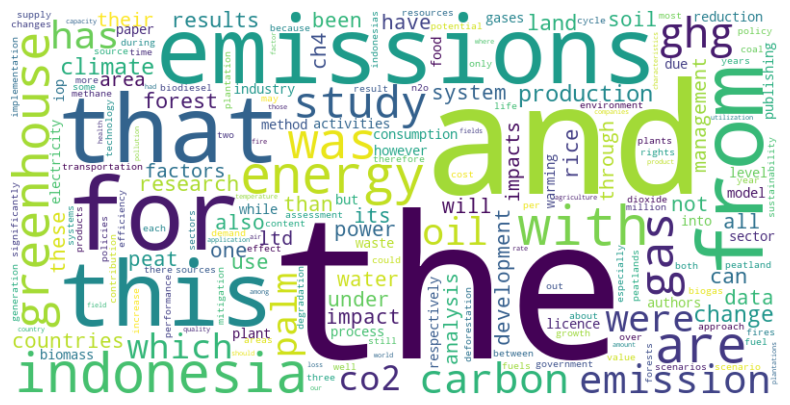

In [18]:
# Visualisasi WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(sorted_result)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
# Ingin mengetahui kata dengan frekuensi terbesar
top20 = dict(abstract_count.most_common(20))
top20_dict = dict(sorted(top20.items(), key=lambda item: (item[1], item[0])))
print(top20_dict)

{'oil': 283, 'has': 291, 'emission': 300, 'carbon': 302, 'ghg': 314, 'study': 339, 'gas': 371, 'greenhouse': 382, 'was': 395, 'are': 407, 'energy': 417, 'with': 451, 'indonesia': 460, 'from': 608, 'this': 629, 'that': 677, 'emissions': 678, 'for': 750, 'and': 2808, 'the': 5030}


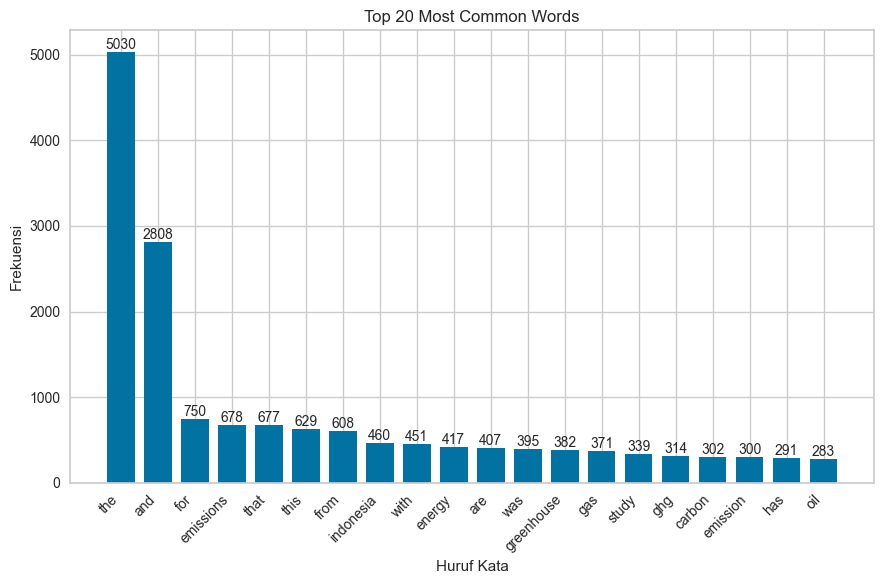

In [20]:
import matplotlib.pyplot as plt

data = {k: v for k, v in sorted(top20_dict.items(), key=lambda item: item[1], reverse=True)}

labels = list(data.keys())
values = list(data.values())
plt.figure(figsize=(9, 6))
plt.bar(labels, values, width=0.75, align='center')

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

plt.ylabel('Frekuensi')
plt.xlabel('Huruf Kata')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Common Words')

plt.tight_layout()
plt.show()


In [21]:
# Save DataFrame to a CSV file untuk diproses lebih lanjut analisisnya
df = pd.DataFrame(list(sorted_result.items()), columns=['Word', 'Counts'])
csv_file_path = 'data_luhn.csv'
df.to_csv(csv_file_path, index=False)